# EnKF Experiments - GCS

## Imports

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy.stats import shapiro, kruskal, mode
import seaborn as sns
import sys

In [2]:
sys.path.append('../../../../stationsim/')
from ensemble_kalman_filter import EnsembleKalmanFilter, AgentIncluder, Inflation, ExitRandomisation, GateEstimator
from stationsim_gcs_model import Model

In [3]:
sys.path.append('../')
from experiment_utils import Modeller, Processor, Visualiser

In [4]:
%matplotlib inline
np.random.seed(42)

## Functions

In [5]:
def tidy_dataframe(df, independent_col: str, dependent_cols: list):
    output = list()
    
    for i, row in df.iterrows():
        for col in dependent_cols:
            d = {independent_col: row[independent_col],
                 'variable':  col,
                 'value': row[col]}
            output.append(d)
    
    output = pd.DataFrame(output)
    return output

## Data paths

In [6]:
data_dir = '../results/data/exp1/'
model_dir = '../results/models/exp1/'
fig_dir = '../results/figures/exp1/'

## Experiment 1 - Setting Up EnKF

### Base model inclusion in error calculations

In [7]:
p = 5
e = 100
a = 100
s = 10

In [8]:
Modeller.run_experiment_1(pop_size=p, ensemble_size=e, assimilation_period=a, obs_noise_std=s,
                          standardise_state=True,
                          inclusion=AgentIncluder.MODE_EN,
                          gate_estimator=GateEstimator.ROUNDING,
                          exit_randomisation=ExitRandomisation.ALL_RANDOM)

/home/keiran/Documents/dev/dust/Projects/ABM_DA/experiments/enkf_experiments/results_3/noteooks/../../../../stationsim/ensemble_kalman_filter.py:208: RuntimeWarning: EnKF received unexpected attribute (vanilla_ensemble_size).
  warns.warn(w, RuntimeWarning)
/home/keiran/Documents/dev/dust/Projects/ABM_DA/experiments/enkf_experiments/results_3/noteooks/../../../../stationsim/ensemble_kalman_filter.py:208: RuntimeWarning: EnKF received unexpected attribute (inflation_rate).
  warns.warn(w, RuntimeWarning)


Running Ensemble Kalman Filter...
max_iterations:	5000
ensemble_size:	100
assimilation_period:	100
pop_size:	5
filter_type:	EnsembleKalmanFilterType.DUAL_EXIT
inclusion_type:	AgentIncluder.MODE_EN
ensemble_errors:	False


In [9]:
Processor.process_experiment_1(pop_size=p)

#### Read data

In [10]:
results = pd.read_csv(data_dir + f'p{p}/metrics.csv')
results.head()

,time,forecast,obs,exit_accuracy,analysis,baseline
0,100,68.477285,10.497560,0.4,9.018959,9.018959
1,200,35.894509,14.465267,0.0,10.075701,10.075701
2,300,40.180116,14.899968,0.6,9.800037,9.800037
3,400,28.993785,9.152527,0.2,9.335631,9.335631
4,500,38.131599,12.289330,0.5,11.939111,11.939111


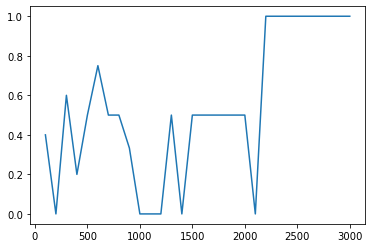

In [11]:
plt.figure()
plt.plot(results['time'], results['exit_accuracy'])
plt.show()

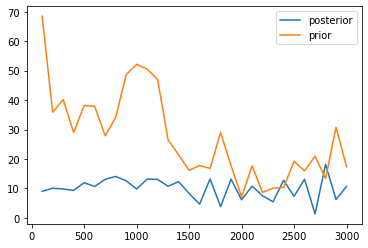

In [12]:
plt.figure()
plt.plot(results['time'], results['analysis'], label='posterior')
plt.plot(results['time'], results['forecast'], label='prior')
plt.legend()
plt.show()

In [13]:
with open(f'../results/models/exp1/p{p}/model.pkl', 'rb') as f:
    enkf = pickle.load(f)

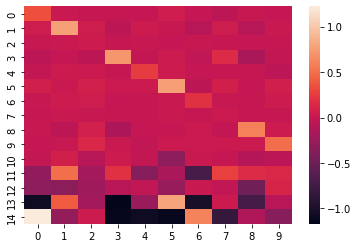

In [14]:
sns.heatmap(enkf.gain_matrix)
plt.show()

In [15]:
print(enkf.gain_matrix)

[[ 3.43275429e-01  1.17805310e-02 -7.48718227e-03 -7.92247239e-03
  -1.92860754e-02  5.14724363e-02 -1.48791303e-02 -5.66532102e-02
   2.13712716e-03 -1.00973945e-02]
 [ 4.49975099e-02  7.59168238e-01  3.73418369e-02 -5.09488506e-02
   2.97634716e-02  7.23812886e-03 -9.07678035e-02  4.30430001e-02
  -9.11671400e-02  1.23188324e-02]
 [ 7.20501586e-03  9.41137565e-03  3.28890640e-02 -9.61243249e-03
   2.45871186e-03 -1.29240488e-02  5.20638922e-03 -2.31719352e-03
  -1.74680527e-02 -8.27788413e-03]
 [-5.67401992e-02 -1.38683760e-02 -5.15150459e-02  7.07226463e-01
  -2.67049840e-02  3.64735534e-02 -3.53224954e-02  1.49964181e-01
  -1.66849268e-01 -2.20667843e-02]
 [-2.08706159e-02  3.20520933e-02  2.08425070e-02 -7.41564562e-03
   2.46583634e-01  3.45343377e-02 -1.34087248e-02 -8.50148810e-03
  -3.45435227e-03 -6.47612794e-02]
 [ 7.26078209e-02  9.06379014e-03  7.94580383e-02  2.54128365e-02
   2.50607789e-02  7.49547348e-01 -5.55019368e-02  6.90430353e-02
  -1.24614097e-02  6.92323468e-02

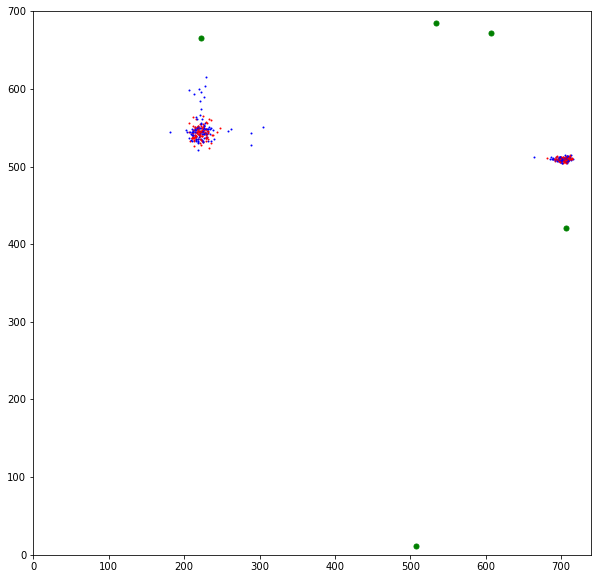

In [16]:
t = -1

plt.figure(figsize=(10, 10))

truth = enkf.results[t]['ground_truth']
truth_x = truth[::2]
truth_y = truth[1::2]
plt.scatter(truth_x, truth_y, color='green', s=25)



for i in range(e):
    prior_label = f'prior_{i}'
    posterior_label = f'posterior_{i}'
    
    prior = enkf.results[t][prior_label]
    posterior = enkf.results[t][posterior_label]
    
    
    prior_x = prior[:2]
    prior_y = prior[2:4]
    posterior_x = posterior[:2]
    posterior_y = posterior[2:4]
    
    plt.scatter(prior_x, prior_y, color='blue', s=1)
    plt.scatter(posterior_x, posterior_y, color='red', s=1)

plt.xlim((0, 740))
plt.ylim((0, 700))
plt.show()

In [17]:
output = list()
for r in enkf.results:
    d = dict()
    # get time
    d['time'] = r['time']
    
    for i in range(enkf.population_size):        
        # get truth
        truth = r['ground_truth']
        d[f'truth_x_{i}'] = truth[2*i]
        d[f'truth_y_{i}'] = truth[(2*i)+1]

        # get prior
        prior = r['prior']
        d[f'prior_x_{i}'] = prior[i]
        d[f'prior_y_{i}'] = prior[i + enkf.population_size]

        # get posterior
        posterior = r['posterior']
        d[f'posterior_x_{i}'] = posterior[i]
        d[f'posterior_y_{i}'] = posterior[i + enkf.population_size]

        # get obs
        obs = r['observation']
        d[f'obs_x_{i}'] = obs[2*i]
        d[f'obs_y_{i}'] = obs[(2*i)+1]

        # get origin and destination
        origin = r['origin']
        d[f'origin_x_{i}'] = origin[2*i]
        d[f'origin_y_{i}'] = origin[(2*i)+1]
        destination = r['destination']
        d[f'dest_x_{i}'] = destination[2*i]
        d[f'dest_y_{i}'] = destination[(2*i)+1]
    
    output.append(d)
    
output = pd.DataFrame(output)


In [18]:
output.head()

,time,truth_x_0,truth_y_0,prior_x_0,prior_y_0,posterior_x_0,posterior_y_0,obs_x_0,obs_y_0,origin_x_0,...,prior_x_4,prior_y_4,posterior_x_4,posterior_y_4,obs_x_4,obs_y_4,origin_x_4,origin_y_4,dest_x_4,dest_y_4
0,100,30.453517,683.419733,145.569266,677.237373,33.197507,682.781491,31.811242,685.829604,6.696759,...,726.782289,476.726363,729.372253,550.985403,724.916002,556.010454,732.65,532.705474,588.963069,692.65
1,200,54.210274,674.189467,53.153902,671.107398,45.943087,671.094313,33.828949,670.010027,6.696759,...,717.238578,535.738953,688.557183,565.880996,678.136168,569.252069,732.65,532.705474,588.963069,692.65
2,300,77.967031,664.959200,66.615122,659.011660,74.936830,665.746755,88.882850,664.059309,6.696759,...,687.125074,555.457908,666.982486,605.752562,666.918824,613.780242,732.65,532.705474,588.963069,692.65
3,400,101.723788,655.728933,98.651490,659.962015,102.562968,662.960334,110.124143,659.421578,6.696759,...,662.029578,608.852029,652.288681,626.688500,653.246067,629.140443,732.65,532.705474,588.963069,692.65
4,500,125.480546,646.498667,126.983702,658.714375,120.959397,644.195932,120.951092,638.467072,6.696759,...,633.306149,630.475784,621.976108,631.960725,618.149407,631.224829,732.65,532.705474,588.963069,692.65


In [19]:
def plot_path(output, aid, show_obs=True, show_od=True):
    print(f'Agent {aid}')
    plt.figure(figsize=(10, 10))
    plt.plot(output[f'truth_x_{aid}'], output[f'truth_y_{aid}'], label=f'truth_{aid}', color='green')
    plt.plot(output[f'prior_x_{aid}'], output[f'prior_y_{aid}'], label=f'prior_{aid}', color='blue')
    plt.plot(output[f'posterior_x_{aid}'], output[f'posterior_y_{aid}'], label=f'posterior_{aid}', color='orange')

    if show_obs:
        plt.scatter(output[f'obs_x_{aid}'], output[f'obs_y_{aid}'], label=f'obs_{aid}', s=1, color='green')
        
    if show_od:
        plt.scatter(output[f'origin_x_{aid}'], output[f'origin_y_{aid}'], label=f'origin_{aid}', s=25, color='blue')
        plt.scatter(output[f'dest_x_{aid}'], output[f'dest_y_{aid}'], label=f'destination_{aid}', s=25, color='orange')

    plt.xlim((0, 740))
    plt.ylim((0, 700))
    plt.legend()
    plt.show()

Agent 0


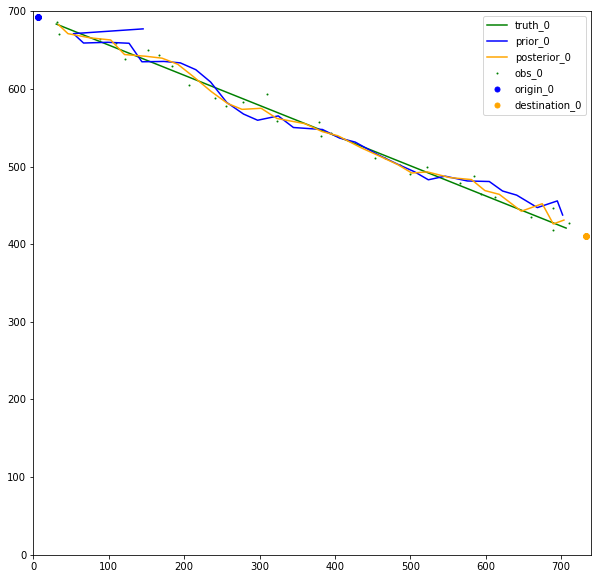

Agent 1


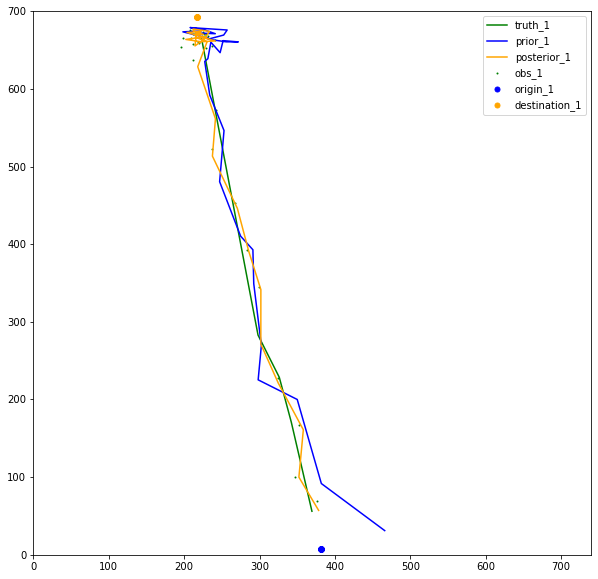

Agent 2


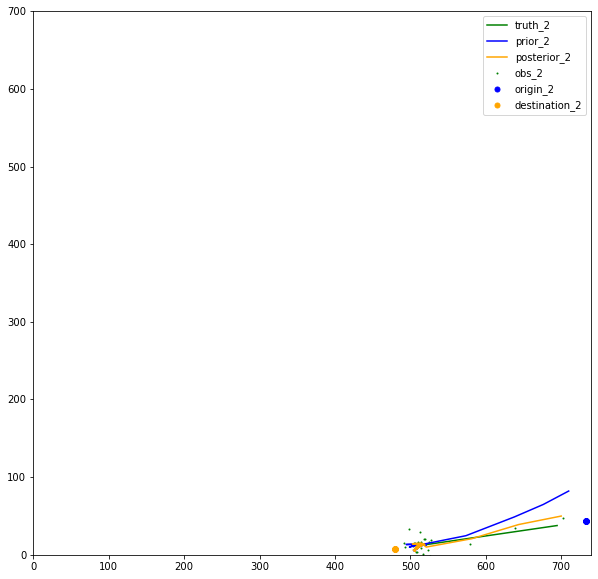

Agent 3


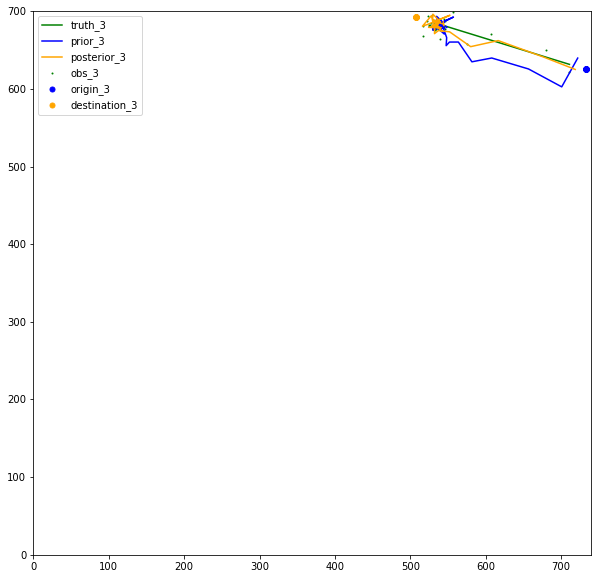

Agent 4


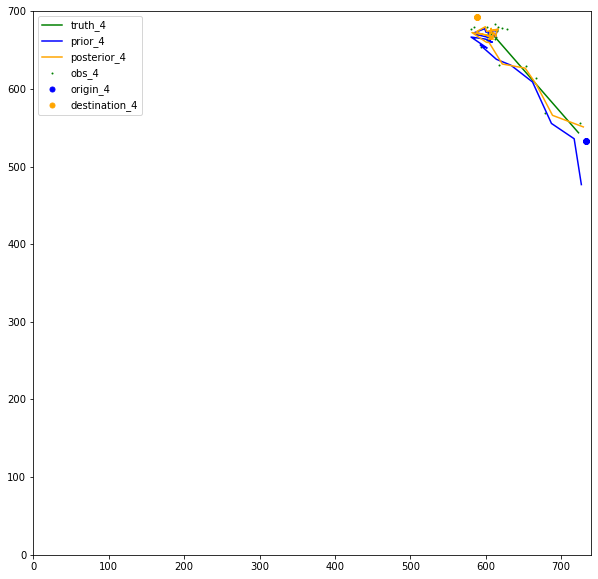

In [20]:
for i in range(enkf.population_size):
    plot_path(output, i)

In [21]:
def present_gate_estimates(agent_number, show_initial=True):
    idx = (2 * enkf.population_size) + agent_number
    true_gate = enkf.base_model.agents[agent_number].gate_out
    print(f'Base model gate value: {true_gate}')

    gate_vals = enkf.state_ensemble[idx]

    if hasattr(enkf, 'gate_angles'):
        gate_edges = enkf.gate_angles[true_gate]
        print(f'Gate edge angles: {gate_edges}')
    else:
        print(f'Ensemble modal gate value: {mode(gate_vals)}')

    print(f'Gate value across ensemble: {gate_vals}')
    
    plt.hist(gate_vals, label='final', alpha=0.5, color='orange')
    if show_initial:
        plt.hist(enkf.initial_gates[agent_number], label='initial', alpha=0.5, color='blue')
    
    plt.legend()
    plt.show()

0
Base model gate value: 4
Ensemble modal gate value: ModeResult(mode=array([4.]), count=array([95]))
Gate value across ensemble: [4. 4. 4. 5. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 5. 4. 4. 4. 4. 4. 4. 4. 4. 4. 3. 4. 4. 5.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 5. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4.]


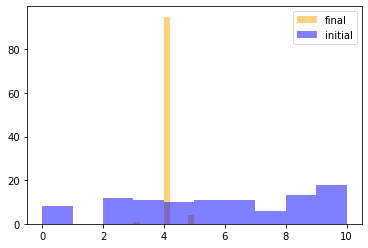

1
Base model gate value: 1
Ensemble modal gate value: ModeResult(mode=array([1.]), count=array([40]))
Gate value across ensemble: [ 3.  0.  1.  2.  1.  0.  1.  5.  1.  0.  2.  1. 10.  3.  1.  1.  0.  1.
  2.  1.  1.  3.  1.  1.  1.  5.  3.  2.  3.  1.  2.  2.  0.  2.  2.  1.
  3.  2.  0.  2.  2. 10.  2.  1.  0.  1.  1.  5.  1.  2.  1.  2.  1.  2.
  3.  1.  2.  2.  3.  1.  3.  1.  2.  0.  0.  2.  1.  1.  1.  2.  1.  3.
  0.  3.  1. 10.  2.  2.  1.  1.  1.  2.  2.  2.  2.  1.  1.  1.  1.  2.
  1.  1.  2.  1.  2.  0.  1.  2.  0.  2.]


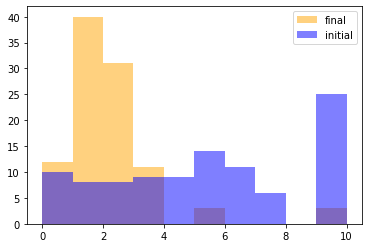

2
Base model gate value: 8
Ensemble modal gate value: ModeResult(mode=array([6.]), count=array([33]))
Gate value across ensemble: [7. 8. 6. 7. 6. 7. 6. 4. 6. 8. 7. 9. 6. 8. 7. 8. 7. 9. 6. 6. 6. 7. 6. 7.
 3. 8. 7. 7. 7. 4. 6. 4. 6. 5. 6. 6. 6. 6. 6. 8. 5. 8. 7. 7. 6. 9. 7. 6.
 8. 7. 8. 7. 8. 6. 6. 7. 7. 6. 6. 8. 6. 7. 8. 8. 8. 6. 6. 4. 7. 5. 7. 7.
 8. 7. 7. 8. 7. 6. 6. 6. 8. 7. 4. 7. 7. 6. 7. 7. 5. 6. 8. 7. 7. 8. 6. 6.
 8. 6. 5. 5.]


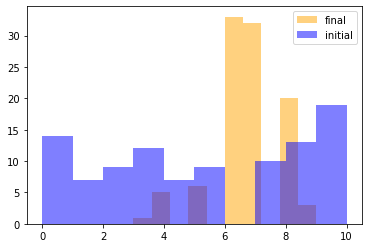

3
Base model gate value: 2
Ensemble modal gate value: ModeResult(mode=array([3.]), count=array([29]))
Gate value across ensemble: [6. 3. 1. 4. 4. 2. 2. 2. 1. 6. 3. 4. 3. 3. 4. 1. 2. 1. 3. 3. 3. 3. 0. 5.
 4. 3. 1. 8. 1. 2. 3. 4. 3. 3. 3. 3. 4. 9. 9. 4. 3. 1. 5. 3. 6. 2. 9. 5.
 4. 4. 4. 2. 2. 3. 3. 5. 4. 6. 3. 4. 4. 2. 2. 2. 1. 6. 3. 3. 4. 4. 3. 2.
 4. 4. 3. 6. 3. 0. 4. 3. 4. 4. 3. 2. 4. 9. 4. 2. 3. 2. 2. 0. 0. 3. 6. 1.
 4. 4. 4. 3.]


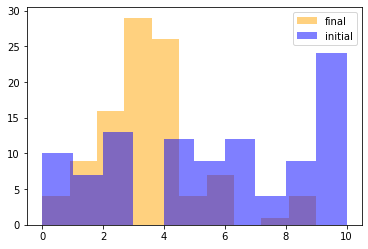

4
Base model gate value: 2
Ensemble modal gate value: ModeResult(mode=array([4.]), count=array([13]))
Gate value across ensemble: [ 8.  0.  4.  3.  2.  8. 10.  0.  4.  8.  5.  8.  7.  3.  4.  6.  9. 10.
  7.  2.  6.  2.  2.  9.  5.  3.  3.  9.  5.  6.  0.  7.  7.  8.  4.  0.
  6.  6. 10.  4.  4.  9.  9.  8.  8.  9.  8.  1.  2.  9.  3.  4.  6.  2.
  6.  2.  8. 10.  7.  9.  3.  2.  5.  6.  8.  4.  2.  8.  4.  6.  7.  1.
  9.  4.  9.  5.  3.  3.  3.  2.  8.  7.  3.  5.  9.  7.  3.  4.  6.  4.
  9.  1.  2.  7.  2.  9.  0.  1.  4.  6.]


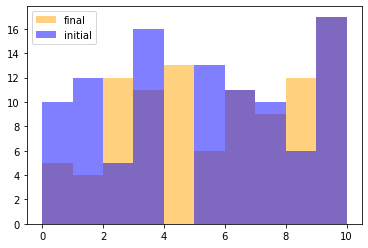

In [22]:
for i in range(enkf.population_size):
    print(i)
    present_gate_estimates(i)

* Look at standardisation
* scaling variables